#Challenge
In this module, you were introduced to the amazing and challenging domain of unsupervised learning; you explored some of the most popular clustering and dimensionality reduction algorithms. Now, it's time for you to apply your unsupervised learning knowledge. 

In this challenge, you'll work with a dataset of your choice. As always, Kaggle will be one of your best friends. Spend some time on Kaggle and pick a beautiful dataset. Then, using that dataset, do the following:

* Apply dimensionality reduction techniques to visualize the observations.
* Apply clustering techniques to group similar observations.

For each of the tasks above, try several methods and select the best-performing one. Discuss how dimensionality reduction and clustering algorithms enable you to gain insights regarding the data.

# Setup and Data Import

In [ ]:
#Installers:
!pip install umap-learn
!pip install prince

In [57]:
#Setup the environment
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import datasets, metrics

import umap
import prince
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read in the dataset directly from GitHub repo:
brdf = pd.read_csv('https://raw.githubusercontent.com/wolfy5878/DSI09-UnsupervisedLearningChallenge/main/IowaLiquorSales_BarbadosRum.csv')

# Check out the data info:
brdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9897 entries, 0 to 9896
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Invoice/Item Number    9897 non-null   object 
 1   Date                   9897 non-null   object 
 2   Store Number           9897 non-null   int64  
 3   Store Name             9897 non-null   object 
 4   Address                9897 non-null   object 
 5   City                   9897 non-null   object 
 6   Zip Code               9897 non-null   object 
 7   Store Location         9897 non-null   object 
 8   County Number          9897 non-null   float64
 9   County                 9897 non-null   object 
 10  Category               9897 non-null   float64
 11  Category Name          9897 non-null   object 
 12  Vendor Number          9897 non-null   float64
 13  Vendor Name            9897 non-null   object 
 14  Item Number            9897 non-null   int64  
 15  Item

In [4]:
#set system options to show in scrollable windows & with rounding
pd.set_option('display.max_rows', brdf.shape[0]+1)
pd.set_option('display.max_columns', brdf.shape[0]+1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('use_inf_as_na', True)


# EDA and Data Prep

In [5]:
#Removing unique ids and unnecessary variables for the scope of our analysis:
brdf.drop(['Invoice/Item Number', 'Store Number', 'Store Name', 'Address', 
          'Store Location', 'County Number', 'Category',  
           'Vendor Number', 'Item Number','Category Name', 'State Bottle Cost',	'State Bottle Retail', 'Volume Sold (Liters)',	'Volume Sold (Gallons)'], axis = 1, inplace=True)

In [6]:
brdf.columns

Index(['Date', 'City', 'Zip Code', 'County', 'Vendor Name', 'Item Description',
       'Pack', 'Bottle Volume (ml)', 'Bottles Sold', 'Sale (Dollars)'],
      dtype='object')

In [7]:
#Convert dollar columns to floats
money_cols = ['Sale (Dollars)']

# pass them to df.replace(), specifying each char and it's replacement:
brdf[money_cols] = brdf[money_cols].replace({'\$': '', ',': ''}, regex=True)
brdf[money_cols] = brdf[money_cols].astype(float)

#drop any NAs that might be in the dataset:
brdf.dropna(inplace=True)

cols = ['Date', 'City', 'Zip Code', 'County', 'Vendor Name', 'Item Description',
       'Pack', 'Bottle Volume (ml)', 'Bottles Sold', 'Sale (Dollars)']

In [8]:
brdf['Item Description'] = brdf['Item Description'].replace({'\.': '', '\*': '', '\'':''}, regex = True)
brdf.shape

(9897, 10)

In [9]:
brdf.head()

,Date,City,Zip Code,County,Vendor Name,Item Description,Pack,Bottle Volume (ml),Bottles Sold,Sale (Dollars)
0,02/06/2014,DES MOINES,50314,Polk,"Moet Hennessy USA, Inc.",10 Cane Rum,6,750,2,37.500
1,08/30/2012,CEDAR RAPIDS,52411,Linn,"Moet Hennessy USA, Inc.",10 Cane Rum,6,750,6,134.820
2,05/15/2014,WATERLOO,50701,Black Hawk,E AND J GALLO WINERY,Shellback Silver,12,750,12,125.880
3,05/30/2012,DES MOINES,50311,Polk,REMY COINTREAU USA .,Mt Gay Eclipse Rum,12,750,3,40.500
4,09/09/2015,AMES,50010,Story,MHW Ltd,Blue Chair Bay White,12,750,2,28.260


In [10]:
#Extract Year and Month into separate columns
brdf['Year'] = pd.DatetimeIndex(brdf['Date']).year.astype(int)
brdf['Month'] = pd.DatetimeIndex(brdf['Date']).month
#Drop date column
brdf.drop(['Date'], axis = 1, inplace=True)

In [11]:
brdf.info()
print()
brdf.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9897 entries, 0 to 9896
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                9897 non-null   object 
 1   Zip Code            9897 non-null   object 
 2   County              9897 non-null   object 
 3   Vendor Name         9897 non-null   object 
 4   Item Description    9897 non-null   object 
 5   Pack                9897 non-null   int64  
 6   Bottle Volume (ml)  9897 non-null   int64  
 7   Bottles Sold        9897 non-null   int64  
 8   Sale (Dollars)      9897 non-null   float64
 9   Year                9897 non-null   int64  
 10  Month               9897 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 927.8+ KB



,City,Zip Code,County,Vendor Name,Item Description,Pack,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Year,Month
0,DES MOINES,50314,Polk,"Moet Hennessy USA, Inc.",10 Cane Rum,6,750,2,37.500,2014,2
1,CEDAR RAPIDS,52411,Linn,"Moet Hennessy USA, Inc.",10 Cane Rum,6,750,6,134.820,2012,8
2,WATERLOO,50701,Black Hawk,E AND J GALLO WINERY,Shellback Silver,12,750,12,125.880,2014,5
3,DES MOINES,50311,Polk,REMY COINTREAU USA .,Mt Gay Eclipse Rum,12,750,3,40.500,2012,5
4,AMES,50010,Story,MHW Ltd,Blue Chair Bay White,12,750,2,28.260,2015,9


In [12]:
brdf.describe()

,Pack,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Year,Month
count,9897.000,9897.000,9897.000,9897.000,9897.000,9897.000
mean,11.277,748.940,5.974,86.204,2014.113,6.859
std,1.953,30.525,7.835,104.622,1.114,3.427
min,6.000,12.000,1.000,7.430,2012.000,1.000
25%,12.000,750.000,2.000,28.260,2013.000,4.000
50%,12.000,750.000,3.000,42.750,2014.000,7.000
75%,12.000,750.000,6.000,125.880,2015.000,10.000
max,12.000,1750.000,294.000,2722.440,2016.000,12.000


In [13]:
brdf.describe(include='O')

,City,Zip Code,County,Vendor Name,Item Description
count,9897,9897,9897,9897,9897
unique,227,200,86,12,30
top,DES MOINES,50010,Polk,REMY COINTREAU USA .,Mt Gay Eclipse Rum
freq,903,499,2618,3984,3549


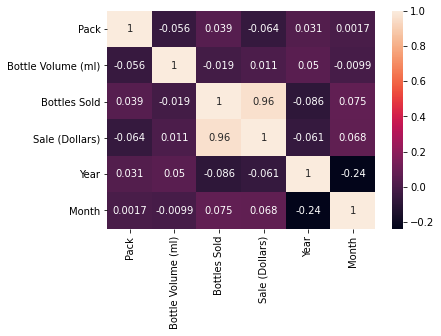

In [14]:
#Checking correlation between numeric variables:
sns.heatmap(brdf.corr(), annot = True)

Not a surprise that Bottles Sold and Sale (Dollars) is highly correlated.

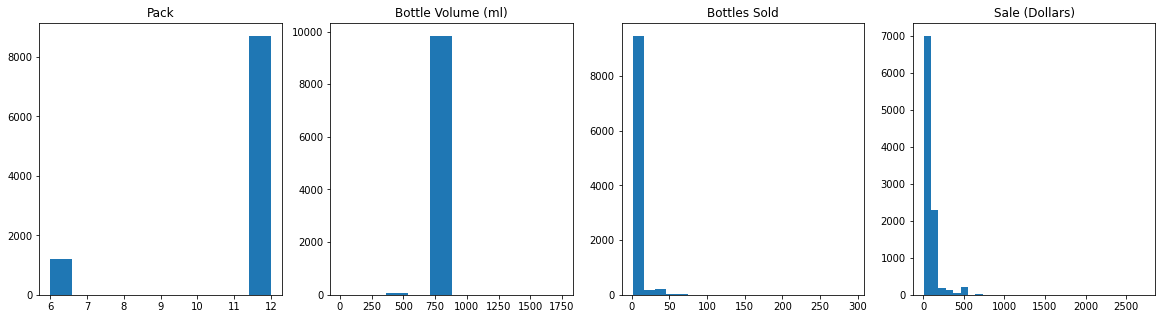

In [15]:
#Checking distribution of numeric variables:
# Histograms:
plt.figure(figsize = (20,5)) # wide, tall
plt.subplot(1,4,1)  # num rows, num col, index
plt.hist(brdf['Pack'])
plt.title("Pack")

plt.subplot(1,4,2)  # num rows, num col, index
plt.hist(brdf['Bottle Volume (ml)'])
plt.title("Bottle Volume (ml)")

plt.subplot(1,4,3)  # num rows, num col, index
plt.hist(brdf['Bottles Sold'], bins = 20)
plt.title("Bottles Sold")

plt.subplot(1,4,4)  # num rows, num col, index
plt.hist(brdf['Sale (Dollars)'], bins=30)
plt.title("Sale (Dollars)")

plt.show()

In [16]:
print('Bottle Volumes: ', brdf['Bottle Volume (ml)'].unique())
print('Packs: ', brdf['Pack'].unique())

Bottle Volumes:  [ 750  500 1750   12]
Packs:  [ 6 12]


Pack and Bottle Volume (ml) could be considered categorical rather than continuous. Bottles Sold and Sale (Dollars) are clearly not normally distributed and not similarly scaled.

Going to look into the distributions of these a bit more and see if we can eliminate extraneous values that aren't useful for our analysis.

In [17]:
under_1000 = brdf['Sale (Dollars)'] <= 1000
print(under_1000.value_counts())
brdf_sa1000 = brdf.iloc[under_1000.values]
print()
under_800 = brdf['Sale (Dollars)'] <= 800
print(under_800.value_counts())
brdf_sa800 = brdf.iloc[under_800.values]
print()
under_600 = brdf['Sale (Dollars)'] <= 600
print(under_600.value_counts())
brdf_sa600 = brdf.iloc[under_600.values]

True     9893
False       4
Name: Sale (Dollars), dtype: int64

True     9883
False      14
Name: Sale (Dollars), dtype: int64

True     9867
False      30
Name: Sale (Dollars), dtype: int64


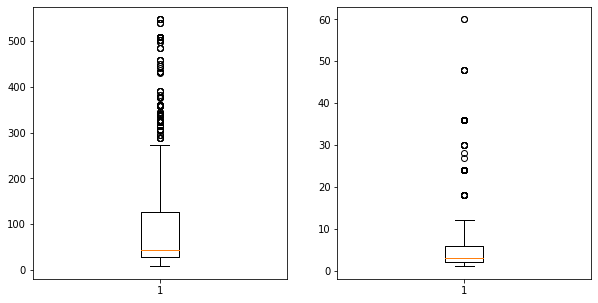

In [18]:
plt.figure(figsize = (10,5)) # wide, tall
plt.subplot(121)
plt.boxplot(brdf_sa600['Sale (Dollars)'])
plt.subplot(122)
plt.boxplot(brdf_sa600['Bottles Sold'])
plt.show()

In [19]:
#Replace the dataframe with the reduced outlier dataframe:
brdf = brdf_sa600

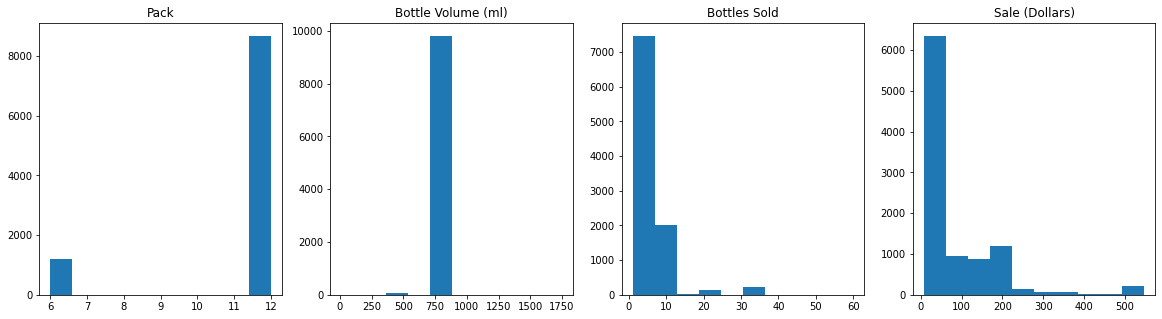

In [20]:
# Histograms:
plt.figure(figsize = (20,5)) # wide, tall
plt.subplot(1,4,1)  # num rows, num col, index
plt.hist(brdf['Pack'])
plt.title("Pack")

plt.subplot(1,4,2)  # num rows, num col, index
plt.hist(brdf['Bottle Volume (ml)'])
plt.title("Bottle Volume (ml)")

plt.subplot(1,4,3)  # num rows, num col, index
plt.hist(brdf['Bottles Sold'])
plt.title("Bottles Sold")

plt.subplot(1,4,4)  # num rows, num col, index
plt.hist(brdf['Sale (Dollars)'])
plt.title("Sale (Dollars)")

plt.show()

That's a little better to get them into visibility for our academic purposes.

We'll decide what to do with the numeric categorical data as well as the normality and scale of the sales columns based on the dimension reduction methods and clustering models we choose.

# Dimension Reduction

##Principal Component Analysis (PCA)

###Data Prep

Before applying PCA, we should always mean normalize our variables and scale the data. Note that standardizing the variables also includes mean normalization, so if we standardize our variables we don't need to mean normalize beforehand.

In [21]:
#Isolate the numeric variables into a df for PCA:
pcadf = brdf.select_dtypes(include=['int64','float64'])
pcadf.head()

,Pack,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Year,Month
0,6,750,2,37.500,2014,2
1,6,750,6,134.820,2012,8
2,12,750,12,125.880,2014,5
3,12,750,3,40.500,2012,5
4,12,750,2,28.260,2015,9


In [22]:
#standardize the data:
scaler = StandardScaler()
pcadf_scaled = scaler.fit_transform(pcadf)

###PCA

In [23]:
pca = PCA(n_components=6)
pcadf_pca = pca.fit_transform(pcadf_scaled)

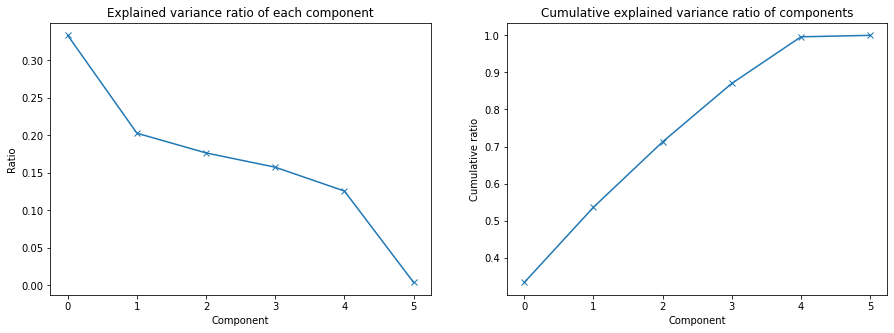

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(0, pca.n_components_), pca.explained_variance_ratio_, "x-")
plt.xlabel("Component")
plt.ylabel("Ratio")
plt.title("Explained variance ratio of each component")
plt.subplot(122)
plt.plot(range(0, pca.n_components_), np.cumsum(pca.explained_variance_ratio_), "x-")
plt.xlabel("Component")
plt.ylabel("Cumulative ratio")
plt.title("Cumulative explained variance ratio of components")
plt.show()

Looks as though a good number of components for this dataset using PCA would be 4 (originally there were 6 variables).

In [25]:
#Adjusting the PCA model to have 4 components:
pca = PCA(n_components=4)
pcadf_pca = pca.fit_transform(pcadf_scaled)

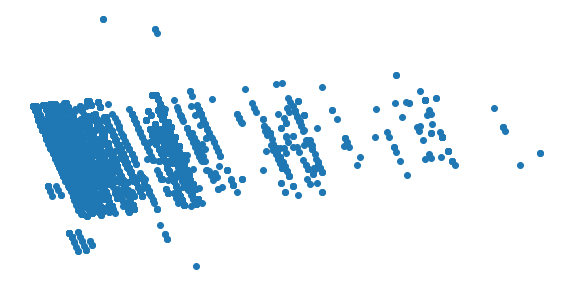

In [27]:
#Visualizing the components:
plt.figure(figsize=(10,5))
plt.scatter(pcadf_pca[:, 0], pcadf_pca[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## Multiple Correspondence Analysis (MCA)

###Data Prep

In [28]:
#Isolate the categorical variables:
#Isolate the numeric variables into a df for PCA:
mcadf = brdf.select_dtypes(include=['object'])
print(mcadf.shape)
mcadf.head()

(9867, 5)


,City,Zip Code,County,Vendor Name,Item Description
0,DES MOINES,50314,Polk,"Moet Hennessy USA, Inc.",10 Cane Rum
1,CEDAR RAPIDS,52411,Linn,"Moet Hennessy USA, Inc.",10 Cane Rum
2,WATERLOO,50701,Black Hawk,E AND J GALLO WINERY,Shellback Silver
3,DES MOINES,50311,Polk,REMY COINTREAU USA .,Mt Gay Eclipse Rum
4,AMES,50010,Story,MHW Ltd,Blue Chair Bay White


###MCA

In [29]:
#Reducing the categorical data down to 2 components:
model = prince.MCA(n_components=5)
mca = model.fit(mcadf)
mcadf_mca = mca.transform(mcadf)
mca.total_inertia_

110.0

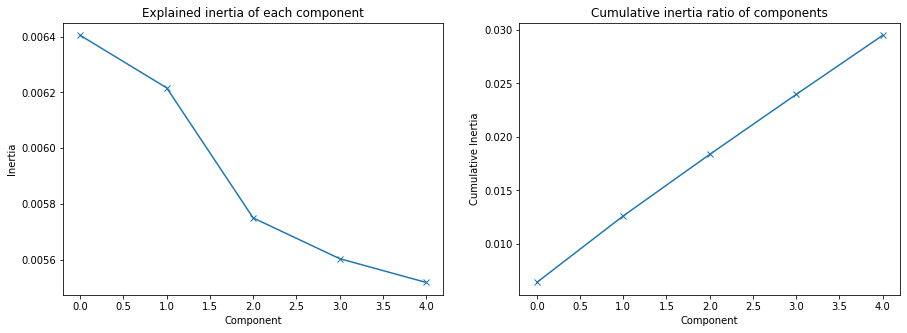

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(0, mca.n_components), mca.explained_inertia_, "x-")
plt.xlabel("Component")
plt.ylabel("Inertia")
plt.title("Explained inertia of each component")
plt.subplot(122)
plt.plot(range(0, mca.n_components), np.cumsum(mca.explained_inertia_), "x-")
plt.xlabel("Component")
plt.ylabel("Cumulative Inertia")
plt.title("Cumulative inertia ratio of components")
plt.show()

Kind of hard to tell what the right number of components would be for this, we'll use two:

In [31]:
#Reducing the categorical data down to 2 components:
model = prince.MCA(n_components=2)
mca = model.fit(mcadf)
mcadf_mca = mca.transform(mcadf)

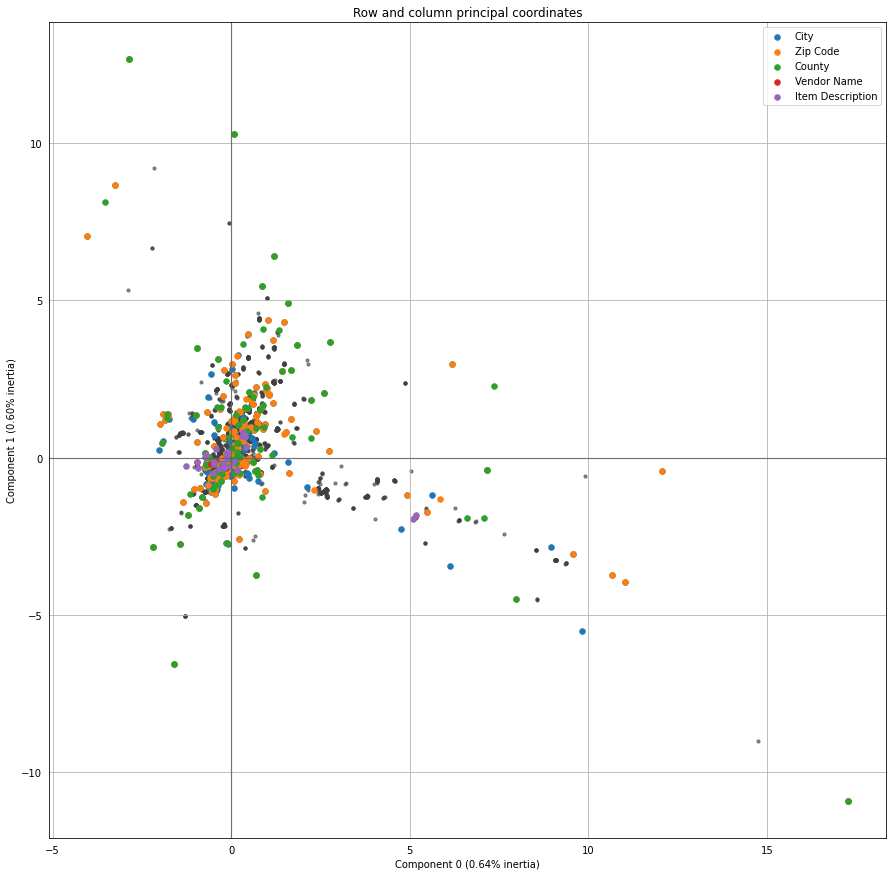

In [32]:
#Visualizing the components:
ax = mca.plot_coordinates(
     X=mcadf,
     ax=None,
     figsize=(15, 15),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
)

We're going to try to one-hot encode and then re-run and see what happens:

In [33]:
mca_onehot = pd.get_dummies(mcadf)
mca_onehot.shape

(9867, 555)

In [34]:
#reduce the one hot encoded df to two dimensions:
model = prince.CA()
ca = model.fit(mca_onehot)
coordinates = ca.transform(mca_onehot)

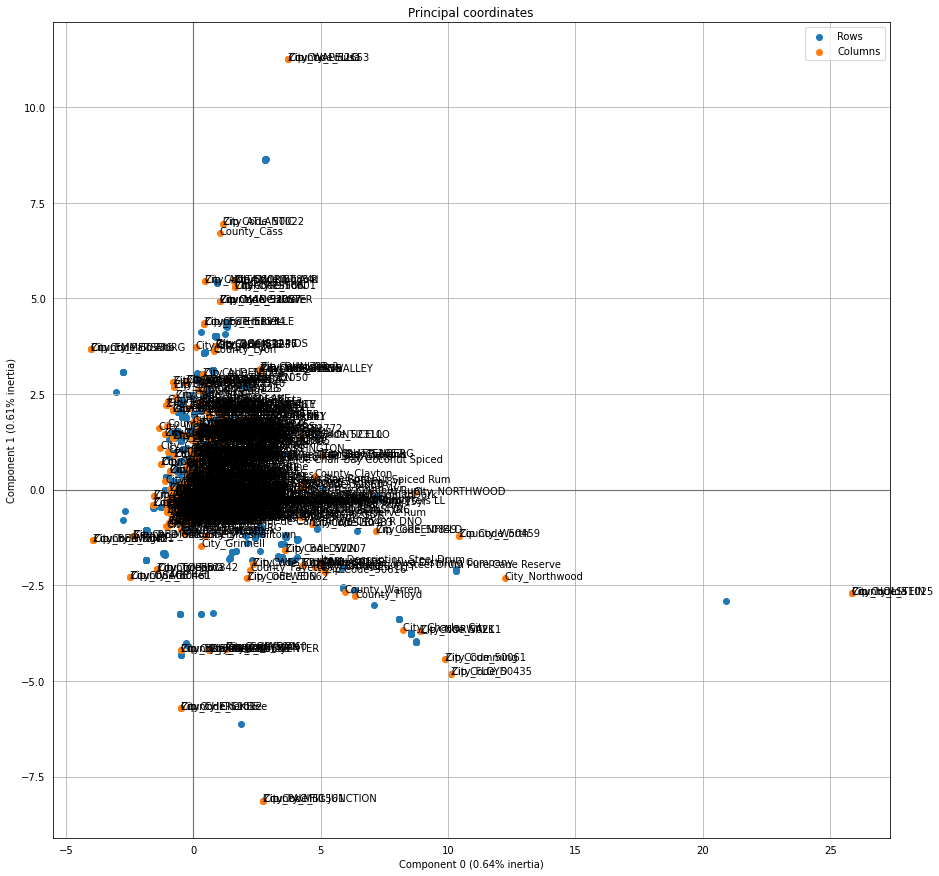

In [35]:
#Visualize the principal coordinates:
ax = ca.plot_coordinates(X=mca_onehot, 
                         ax=None, 
                         figsize=(15, 15), 
                         x_component=0, 
                         y_component=1, 
                         show_row_labels=False, 
                         show_col_labels=True
                         )

That is still not readable.

## Factor Analysis of Mixed Data (FAMD)

### Data Prep

FAMD works best when there are relatively few categorical variables compared to numeric ones, we have a good number of categorical and numeric variables so we'll work with them as they are.

In [36]:
#Copying df for this dim reduction to keep it separate from the above.
famddf = brdf.copy()

### FAMD

In [37]:
famd = prince.FAMD(n_components=10)
famddf_famd = famd.fit_transform(famddf)

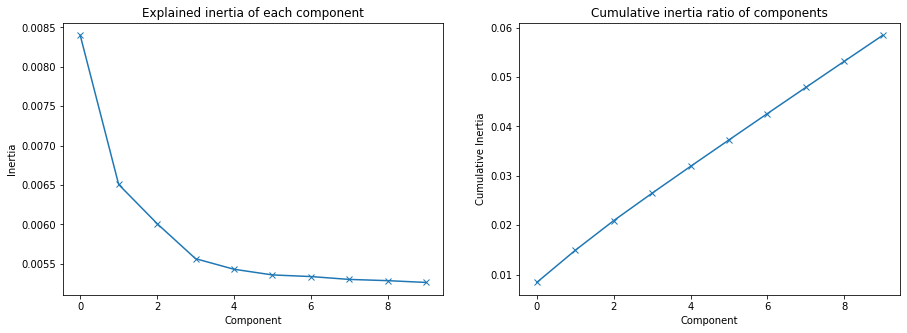

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(0, famd.n_components), famd.explained_inertia_, "x-")
plt.xlabel("Component")
plt.ylabel("Inertia")
plt.title("Explained inertia of each component")
plt.subplot(122)
plt.plot(range(0, famd.n_components), np.cumsum(famd.explained_inertia_), "x-")
plt.xlabel("Component")
plt.ylabel("Cumulative Inertia")
plt.title("Cumulative inertia ratio of components")
plt.show()

In terms of inertia for this model, it looks as though 3 is a good number of components to reduce to.

In [99]:
#Using 4 as the number of components:
famd = prince.FAMD(n_components=3)
famddf_famd = famd.fit_transform(famddf)

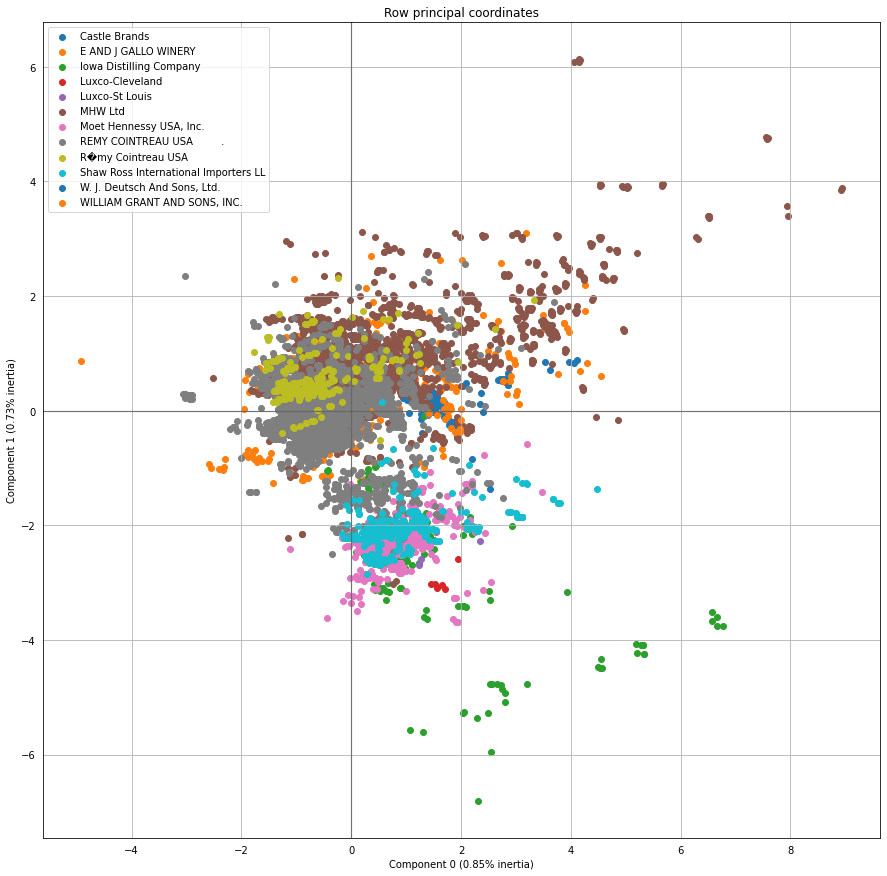

In [102]:
#Visualizing the first couple of components by vendor:
famd.plot_row_coordinates(
    X=famddf,
    figsize=(15, 15),
    color_labels=famddf['Vendor Name'],
    ellipse_outline=False,
    ellipse_fill=False,
)
plt.show()

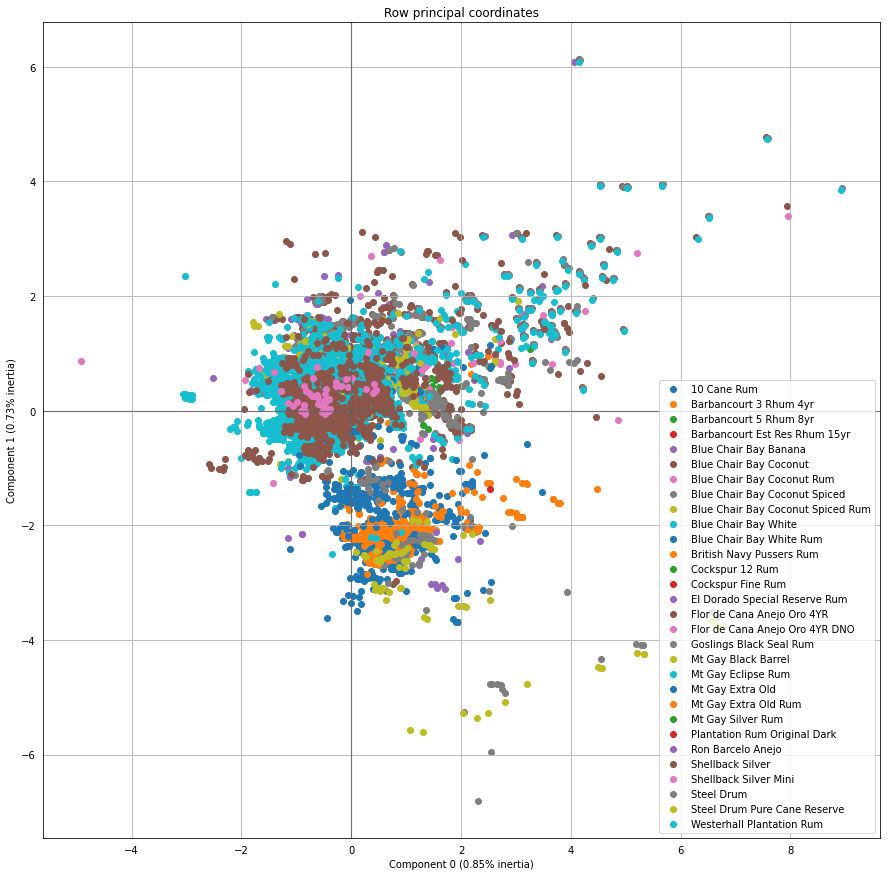

In [103]:
#Visualizing the first couple of components by item description:
famd.plot_row_coordinates(
    X=famddf,
    figsize=(15, 15),
    color_labels=famddf['Item Description'],
    ellipse_outline=False,
    ellipse_fill=False,
)
plt.show()

#Clustering Models

##k-Means

Resetting the number of components to 2 and then using the PCA output, I'm going to use k-Means clustering and visualization:


In [65]:
#Adjusting the PCA model to have 2 components:
pca = PCA(n_components=2)
pcadf_pca = pca.fit_transform(pcadf_scaled)

In [85]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=6, random_state=42, max_iter=500)

# Fit model
%timeit kmeans_cluster.fit(pcadf_pca)
km_y_pred = kmeans_cluster.predict(pcadf_pca)
print()
print("The silhouette score of the k-Means solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, km_y_pred, metric='euclidean')))

1 loop, best of 5: 249 ms per loop

The silhouette score of the k-Means solution: 0.4598206796880759


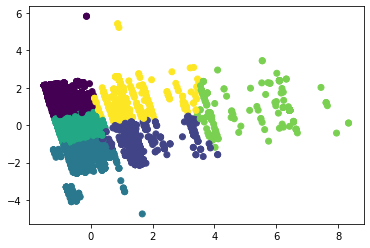

In [86]:
# Plot the solution.
plt.scatter(pcadf_pca[:,0], pcadf_pca[:,1], c=km_y_pred)
plt.show()

##GMM

In [97]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=6, random_state=42, max_iter=500)

# Fit model
%timeit clusters = gmm_cluster.fit(pcadf_pca)
gmm_y_pred = gmm_cluster.predict(pcadf_pca)
print()
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, gmm_y_pred, metric='euclidean')))

1 loop, best of 5: 249 ms per loop

The silhoutte score of the GMM solution: 0.2758386807269408


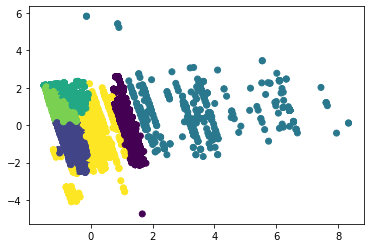

In [98]:
# Plot the solution.
plt.scatter(pcadf_pca[:,0], pcadf_pca[:,1], c=gmm_y_pred)
plt.show()

#Observations


The dimensionality reduction techniques didn't really show any discernable distinct groupings for the unlabeled data. I chose PCA to move forward with the clustering to see how that would perform using k-Means and GMM. 

It appears that the k-Means clustering performed better than the GMM, given both the visualization of the clusters as well as the silhouette score for each.